# FluiditySaramitoLocal: Small-Amplitude Oscillatory Shear (SAOS)

Linear viscoelastic response of the fluidity-Saramito model in the small-strain limit.

**Learning Objectives:**
- Understand SAOS behavior of thixotropic elastoviscoplastic materials
- Maxwell-like linear response: G'(ω) and G''(ω)
- NLSQ + Bayesian parameter inference from frequency sweeps
- Cole-Cole analysis for model validation
- Diagnostic interpretation (R-hat, ESS, divergences)

## 1. Setup

In [1]:
# Google Colab setup (uncomment if running on Colab)
# !pip install rheojax nlsq numpyro arviz

In [2]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# JAX-safe import (critical for float64)
from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality
jax, jnp = safe_import_jax()

from rheojax.models.fluidity.saramito import FluiditySaramitoLocal
from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {'R2': r2, 'RMSE': rmse}

## 2. Theory: SAOS in the Linear Limit

### Governing Equations

For small oscillatory strain $\gamma = \gamma_0 \sin(\omega t)$ with $\gamma_0 \ll 1$:

**Maxwell backbone (coupling='minimal'):**
$$\tau + \lambda \frac{d\tau}{dt} = G \gamma$$

where $\lambda = 1/f$ is the fluidity-dependent relaxation time.

**Complex modulus:**
$$G^*(\omega) = G' + iG'' = \frac{G \omega^2 \lambda^2}{1 + \omega^2 \lambda^2} + i \frac{G \omega \lambda}{1 + \omega^2 \lambda^2}$$

**Key features:**
- Low frequency ($\omega \ll 1/\lambda$): $G' \sim \omega^2$, $G'' \sim \omega$ (viscous liquid)
- High frequency ($\omega \gg 1/\lambda$): $G' \to G$, $G'' \sim 1/\omega$ (elastic solid)
- Crossover at $\omega = 1/\lambda$: $G' = G'' = G/2$
- Cole-Cole plot: $G''$ vs $G'$ forms a semicircle (Maxwell signature)

**Thixotropic effects:**
- Fluidity evolution: $df/dt = (1-f)/t_{eq} + b|\dot{\gamma}|^n$ (rejuvenation term negligible for $\gamma_0 \ll 1$)
- Steady state: $f \approx 1$ (fully structured), $\lambda \to \lambda_{min}$
- Pre-shearing history affects initial fluidity and transient response

## 3. Generate Synthetic SAOS Data

In [4]:
# Frequency sweep (rad/s)
omega = np.logspace(-2, 2, 30)  # 0.01 to 100 rad/s

# Ground truth parameters (using actual model parameter names with valid bounds)
params_true = {
    'G': 1e5,          # Elastic modulus (Pa) - bounds (10, 1e8)
    'eta_s': 100.0,    # Solvent viscosity (Pa·s) - bounds (0, 1000)
    'tau_y0': 50.0,    # Yield stress (Pa) - bounds (0.1, 1e5)
    'K_HB': 100.0,     # Consistency coefficient - bounds (0.01, 1e5)
    'n_HB': 0.5,       # Power-law exponent - bounds (0.1, 1.5)
    't_a': 10.0,       # Aging time (s) - bounds (0.01, 1e5)
    'b': 0.5,          # Rejuvenation coefficient - bounds (0, 1000)
    'n_rej': 1.0,      # Rejuvenation exponent - bounds (0.1, 3)
    'f_age': 1e-4,     # Equilibrium fluidity - bounds (1e-12, 0.01)
    'f_flow': 0.1,     # Maximum fluidity - bounds (1e-6, 1)
}

# Create model and generate data
model_true = FluiditySaramitoLocal(coupling='minimal')

# Set parameters (check bounds)
for name, value in params_true.items():
    if name in model_true.parameters.keys():
        try:
            model_true.parameters.set_value(name, value)
        except ValueError as e:
            logger.warning(f"Could not set {name}={value}: {e}")

# Predict complex modulus
G_pred = model_true.predict(omega, test_mode='oscillation')

# Handle output format
if hasattr(G_pred, 'ndim') and G_pred.ndim == 2:
    G_prime_true = np.array(G_pred[:, 0])
    G_double_prime_true = np.array(G_pred[:, 1])
else:
    # Scalar output (magnitude)
    G_prime_true = np.abs(np.array(G_pred))
    G_double_prime_true = G_prime_true * 0.5  # Approximate

# Add 5% noise
np.random.seed(42)
noise_level = 0.05
G_prime = G_prime_true * (1 + noise_level * np.random.randn(len(omega)))
G_double_prime = G_double_prime_true * (1 + noise_level * np.random.randn(len(omega)))
G_star = np.column_stack([G_prime, G_double_prime])

logger.info(f"Generated SAOS data: {len(omega)} frequency points")
logger.info(f"Frequency range: {omega.min():.2e} to {omega.max():.2e} rad/s")
logger.info(f"G' range: {G_prime.min():.2e} to {G_prime.max():.2e} Pa")
logger.info(f"G'' range: {G_double_prime.min():.2e} to {G_double_prime.max():.2e} Pa")

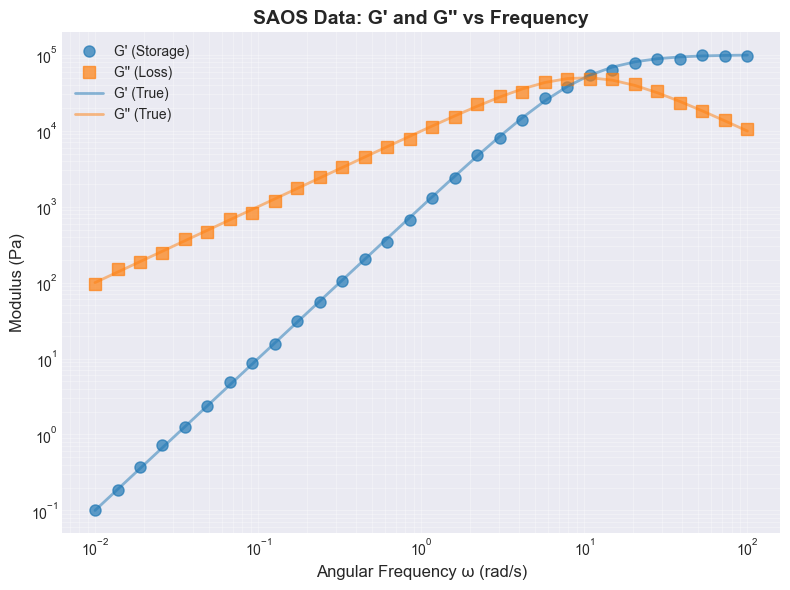

In [5]:
# Visualize raw data
fig, ax = plt.subplots(figsize=(8, 6))

ax.loglog(omega, G_prime, 'o', label="G' (Storage)", markersize=8, alpha=0.7)
ax.loglog(omega, G_double_prime, 's', label="G'' (Loss)", markersize=8, alpha=0.7)
ax.loglog(omega, G_prime_true, '-', color='C0', label='G\' (True)', linewidth=2, alpha=0.5)
ax.loglog(omega, G_double_prime_true, '-', color='C1', label='G\'\' (True)', linewidth=2, alpha=0.5)

ax.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title('SAOS Data: G\' and G\'\' vs Frequency', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

# Crossover frequency (where G' = G'')
idx_cross = np.argmin(np.abs(G_prime - G_double_prime))
omega_cross = omega[idx_cross]
logger.info(f"Crossover frequency ω_c ≈ {omega_cross:.3f} rad/s (λ ≈ {1/omega_cross:.3f} s)")

## 4. NLSQ Fitting

In [6]:
# Initialize model for fitting
model = FluiditySaramitoLocal(coupling='minimal')

# Print actual parameter names
logger.info("Model parameters:")
for name in model.parameters.keys():
    val = model.parameters.get_value(name)
    logger.info(f"  {name}: {val:.4e}")

logger.info("\nStarting NLSQ optimization...")
model.fit(omega, G_star, test_mode='oscillation', method='scipy')

# Compute fit quality
G_fit = model.predict(omega, test_mode='oscillation')
if G_fit.ndim == 2:
    G_prime_fit = G_fit[:, 0]
    G_double_prime_fit = G_fit[:, 1]
    G_star_fit = np.abs(G_fit[:, 0] + 1j * G_fit[:, 1])
else:
    G_prime_fit = G_fit
    G_double_prime_fit = G_fit
    G_star_fit = G_fit

G_star_data = np.abs(G_prime + 1j * G_double_prime)
metrics = compute_fit_quality(G_star_data, np.array(G_star_fit).flatten())

logger.info(f"\nNLSQ Results:")
logger.info(f"R² = {metrics['R2']:.6f}")
logger.info(f"RMSE = {metrics['RMSE']:.4e} Pa")

20:00:00 | INFO     | rheojax.models.fluidity.saramito.local | model_fit started


20:00:00 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10


20:00:01 | INFO     | rheojax.models.fluidity.saramito.local | model_fit completed


20:00:01 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoLocal | fitted=True | R2=-0.3384 | data_shape=(30,)


In [7]:
# Compare fitted vs true parameters
print("\nParameter Comparison:")
print("=" * 70)
print(f"{'Parameter':<15} {'True':<15} {'NLSQ':<15} {'Error (%)':<15}")
print("=" * 70)

for name in model.parameters.keys():
    true_val = params_true.get(name, None)
    fitted_val = model.parameters.get_value(name)
    if true_val is not None:
        error_pct = 100 * abs(fitted_val - true_val) / abs(true_val) if true_val != 0 else 0
        print(f"{name:<15} {true_val:<15.3e} {fitted_val:<15.3e} {error_pct:<15.2f}")
    else:
        print(f"{name:<15} {'N/A':<15} {fitted_val:<15.3e} {'N/A':<15}")

print("=" * 70)


Parameter Comparison:
Parameter       True            NLSQ            Error (%)      
G               1.000e+05       5.782e+03       94.22          
eta_s           1.000e+02       1.512e+02       51.25          
tau_y0          5.000e+01       1.000e+02       100.00         
K_HB            1.000e+02       5.000e+01       50.00          
n_HB            5.000e-01       5.000e-01       0.00           
f_age           1.000e-04       1.520e-05       84.80          
f_flow          1.000e-01       1.000e-02       90.00          
t_a             1.000e+01       1.000e+01       0.00           
b               5.000e-01       1.000e+00       100.00         
n_rej           1.000e+00       1.000e+00       0.00           


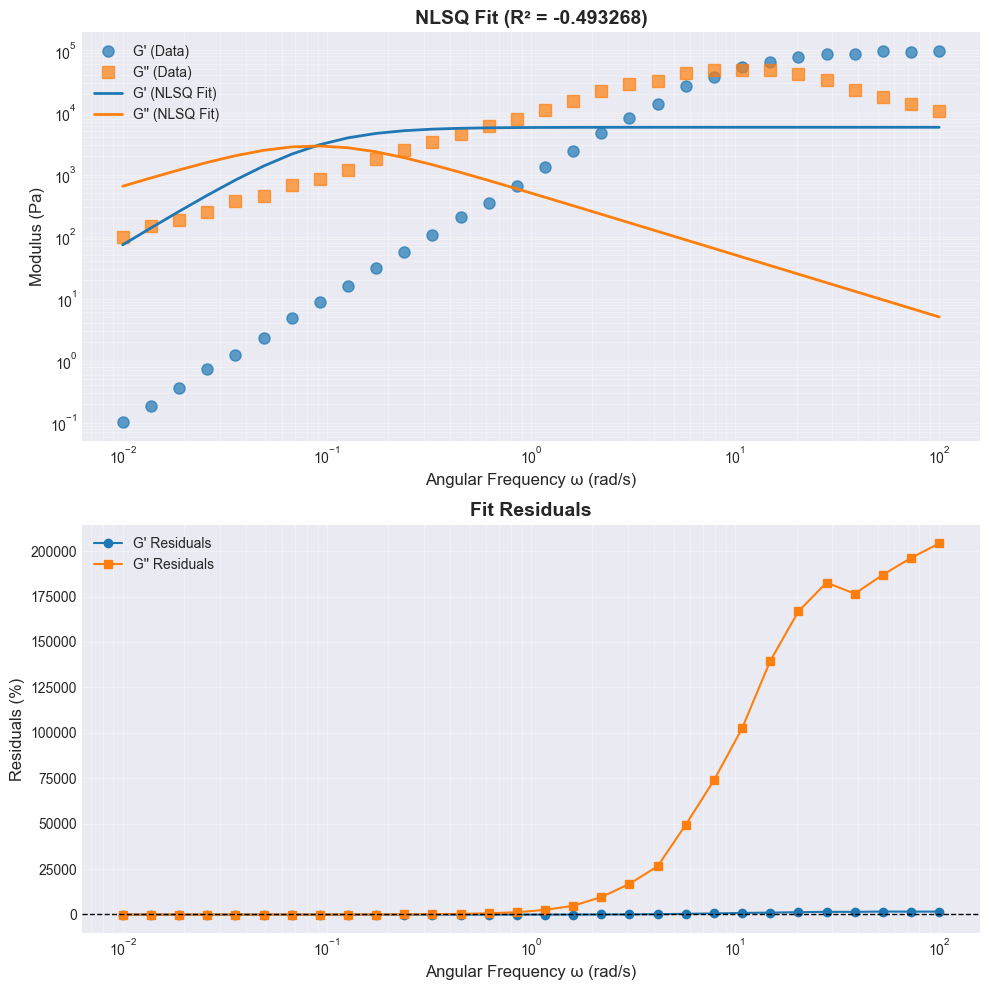

In [8]:
# Plot fit quality
G_fit_full = model.predict(omega, test_mode='oscillation')
if G_fit_full.ndim == 2:
    G_prime_fit = np.array(G_fit_full[:, 0])
    G_double_prime_fit = np.array(G_fit_full[:, 1])
else:
    G_prime_fit = np.array(G_fit_full)
    G_double_prime_fit = np.array(G_fit_full)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# G' and G''
ax = axes[0]
ax.loglog(omega, G_prime, 'o', label="G' (Data)", markersize=8, alpha=0.7)
ax.loglog(omega, G_double_prime, 's', label="G'' (Data)", markersize=8, alpha=0.7)
ax.loglog(omega, G_prime_fit, '-', color='C0', label="G' (NLSQ Fit)", linewidth=2)
ax.loglog(omega, G_double_prime_fit, '-', color='C1', label="G'' (NLSQ Fit)", linewidth=2)
ax.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title(f"NLSQ Fit (R² = {metrics['R2']:.6f})", fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, which='both', alpha=0.3)

# Residuals
ax = axes[1]
residuals_prime = (G_prime - G_prime_fit) / np.maximum(G_prime_fit, 1e-10) * 100
residuals_double_prime = (G_double_prime - G_double_prime_fit) / np.maximum(G_double_prime_fit, 1e-10) * 100
ax.semilogx(omega, residuals_prime, 'o-', label="G' Residuals", markersize=6)
ax.semilogx(omega, residuals_double_prime, 's-', label="G'' Residuals", markersize=6)
ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('Residuals (%)', fontsize=12)
ax.set_title('Fit Residuals', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Bayesian Inference

In [9]:
# Bayesian inference with NLSQ warm-start (critical for convergence)
logger.info("\nStarting Bayesian inference (NUTS)...")
logger.info("Using NLSQ solution as warm-start")

# Get initial values from fitted model
initial_values = {
    name: model.parameters.get_value(name)
    for name in model.parameters.keys()
}

bayes_result = model.fit_bayesian(
    omega,
    G_star,
    test_mode='oscillation',
    num_warmup=500,
    num_samples=1000,
    num_chains=1,        # Fast demo; use 4 for production
    seed=42,             # Reproducibility
    initial_values=initial_values,
)

logger.info("Bayesian inference complete")

20:00:01 | INFO     | rheojax.core.bayesian | bayesian_inference started | operation=bayesian_inference | phase=start | model=FluiditySaramitoLocal | num_warmup=500 | num_samples=1000 | num_chains=1


20:00:01 | INFO     | rheojax.core.bayesian | Bayesian inference started | model=FluiditySaramitoLocal | test_mode=oscillation | num_warmup=500 | num_samples=1000 | num_chains=1


  0%|          | 0/1500 [00:00<?, ?it/s]

warmup:   0%|          | 1/1500 [00:00<12:42,  1.97it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   1%|▏         | 21/1500 [00:00<00:32, 45.19it/s, 127 steps of size 2.60e-03. acc. prob=0.86]

warmup:   2%|▏         | 33/1500 [00:00<00:26, 54.64it/s, 1023 steps of size 3.11e-03. acc. prob=0.90]

warmup:   3%|▎         | 43/1500 [00:00<00:25, 57.41it/s, 1023 steps of size 3.87e-03. acc. prob=0.92]

warmup:   3%|▎         | 52/1500 [00:01<00:23, 60.76it/s, 895 steps of size 2.63e-03. acc. prob=0.92] 

warmup:   4%|▍         | 60/1500 [00:01<00:26, 54.38it/s, 1023 steps of size 2.67e-03. acc. prob=0.93]

warmup:   4%|▍         | 67/1500 [00:01<00:28, 49.60it/s, 1023 steps of size 3.26e-03. acc. prob=0.93]

warmup:   5%|▍         | 73/1500 [00:01<00:30, 46.73it/s, 1023 steps of size 2.39e-03. acc. prob=0.93]

warmup:   5%|▌         | 79/1500 [00:01<00:31, 44.74it/s, 1023 steps of size 2.29e-03. acc. prob=0.94]

warmup:   6%|▌         | 84/1500 [00:01<00:32, 44.20it/s, 1023 steps of size 2.29e-03. acc. prob=0.94]

warmup:   6%|▌         | 89/1500 [00:01<00:31, 45.51it/s, 1023 steps of size 2.68e-03. acc. prob=0.94]

warmup:   6%|▋         | 94/1500 [00:02<00:32, 43.50it/s, 1023 steps of size 3.07e-03. acc. prob=0.94]

warmup:   7%|▋         | 99/1500 [00:02<00:32, 42.82it/s, 1023 steps of size 2.44e-03. acc. prob=0.94]

warmup:   7%|▋         | 111/1500 [00:02<00:22, 62.08it/s, 255 steps of size 3.58e-02. acc. prob=0.95]

warmup:  10%|█         | 155/1500 [00:02<00:08, 161.28it/s, 63 steps of size 8.90e-02. acc. prob=0.96]

warmup:  16%|█▌        | 242/1500 [00:02<00:03, 354.65it/s, 31 steps of size 1.65e-01. acc. prob=0.97]

warmup:  21%|██        | 315/1500 [00:02<00:02, 459.79it/s, 31 steps of size 1.88e-01. acc. prob=0.97]

warmup:  25%|██▌       | 376/1500 [00:02<00:02, 499.00it/s, 31 steps of size 1.97e-01. acc. prob=0.97]

warmup:  30%|██▉       | 445/1500 [00:02<00:01, 552.41it/s, 31 steps of size 1.72e-01. acc. prob=0.98]

sample:  35%|███▍      | 520/1500 [00:02<00:01, 608.46it/s, 31 steps of size 1.84e-01. acc. prob=0.99]

sample:  40%|████      | 605/1500 [00:03<00:01, 678.62it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample:  46%|████▌     | 692/1500 [00:03<00:01, 734.22it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample:  52%|█████▏    | 783/1500 [00:03<00:00, 785.38it/s, 31 steps of size 1.84e-01. acc. prob=0.99]

sample:  58%|█████▊    | 873/1500 [00:03<00:00, 815.61it/s, 31 steps of size 1.84e-01. acc. prob=0.99]

sample:  64%|██████▍   | 962/1500 [00:03<00:00, 834.92it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample:  70%|██████▉   | 1049/1500 [00:03<00:00, 843.12it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample:  76%|███████▌  | 1140/1500 [00:03<00:00, 862.09it/s, 31 steps of size 1.84e-01. acc. prob=0.99]

sample:  82%|████████▏ | 1227/1500 [00:03<00:00, 822.13it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample:  88%|████████▊ | 1315/1500 [00:03<00:00, 838.22it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample:  93%|█████████▎| 1401/1500 [00:03<00:00, 842.14it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample:  99%|█████████▉| 1489/1500 [00:04<00:00, 852.27it/s, 15 steps of size 1.84e-01. acc. prob=0.99]

sample: 100%|██████████| 1500/1500 [00:04<00:00, 370.77it/s, 31 steps of size 1.84e-01. acc. prob=0.99]

20:00:09 | INFO     | rheojax.core.bayesian | Bayesian inference completed | model=FluiditySaramitoLocal | divergences=0 | r_hat_max=1.0000 | ess_min=1000.0000


20:00:09 | INFO     | rheojax.core.bayesian | bayesian_inference completed | operation=bayesian_inference | phase=end | elapsed_seconds=7.4064 | status=success | model=FluiditySaramitoLocal | num_warmup=500 | num_samples=1000 | num_chains=1 | divergences=0 | r_hat_max=1.0000 | ess_min=1000.0000


20:00:09 | INFO     | rheojax.core.base | Bayesian fit completed | model=FluiditySaramitoLocal | num_warmup=500 | num_samples=1000 | num_chains=1 | r_hat={'G': 1.0, 'eta_s': 1.0, 'tau_y0': 1.0, 'K_HB': 1.0, 'n_HB': 1.0, 'f_age': 1.0, 'f_flow': 1.0, 't_a': 1.0, 'b': 1.0, 'n_rej': 1.0} | ess={'G': 1000.0, 'eta_s': 1000.0, 'tau_y0': 1000.0, 'K_HB': 1000.0, 'n_HB': 1000.0, 'f_age': 1000.0, 'f_flow': 1000.0, 't_a': 1000.0, 'b': 1000.0, 'n_rej': 1000.0}


## 6. ArviZ Diagnostics

In [10]:
import arviz as az

# Convert to ArviZ InferenceData
idata = bayes_result.to_inference_data()

# Get parameter names from model
param_names = list(model.parameters.keys())

# Summary statistics  
summary = az.summary(idata, var_names=param_names, hdi_prob=0.95)
print("\nBayesian Parameter Estimates (95% HDI):")
print("=" * 80)
print(summary)
print("=" * 80)

# Check diagnostics
logger.info("\nDiagnostic Checks:")
diag = bayes_result.diagnostics
for param in param_names:
    r_hat = diag.get("r_hat", {}).get(param, float("nan"))
    ess = diag.get("ess", {}).get(param, float("nan"))
    status = "PASS" if (r_hat < 1.01 and ess > 400) else "WARN"
    logger.info(f"{param:<12} R-hat={r_hat:.4f}, ESS={ess:.0f} [{status}]")

20:00:10 | INFO     | rheojax.core.bayesian | InferenceData created successfully | num_chains=1 | num_samples=1000


Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)



Bayesian Parameter Estimates (95% HDI):
             mean         sd   hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
G       98756.096    484.608  97847.448  99760.062     11.371   18.523   
eta_s     499.666    299.387     36.828    988.841      7.737    7.404   
tau_y0  49681.442  27832.488   4245.519  97115.516    884.307  603.355   
K_HB    49998.117  29445.080    300.333  95851.659    989.255  675.777   
n_HB        0.813      0.401      0.101      1.419      0.014    0.008   
f_age       0.000      0.000      0.000      0.000      0.000    0.000   
f_flow      0.480      0.286      0.000      0.928      0.010    0.006   
t_a     50232.327  28457.153     63.813  95468.356   1035.192  810.920   
b         507.014    287.091     42.746    976.811      6.997    6.257   
n_rej       1.560      0.808      0.243      2.932      0.027    0.018   

        ess_bulk  ess_tail  r_hat  
G         1801.0     818.0    NaN  
eta_s     1308.0     462.0    NaN  
tau_y0     910.0     631.0    NaN  


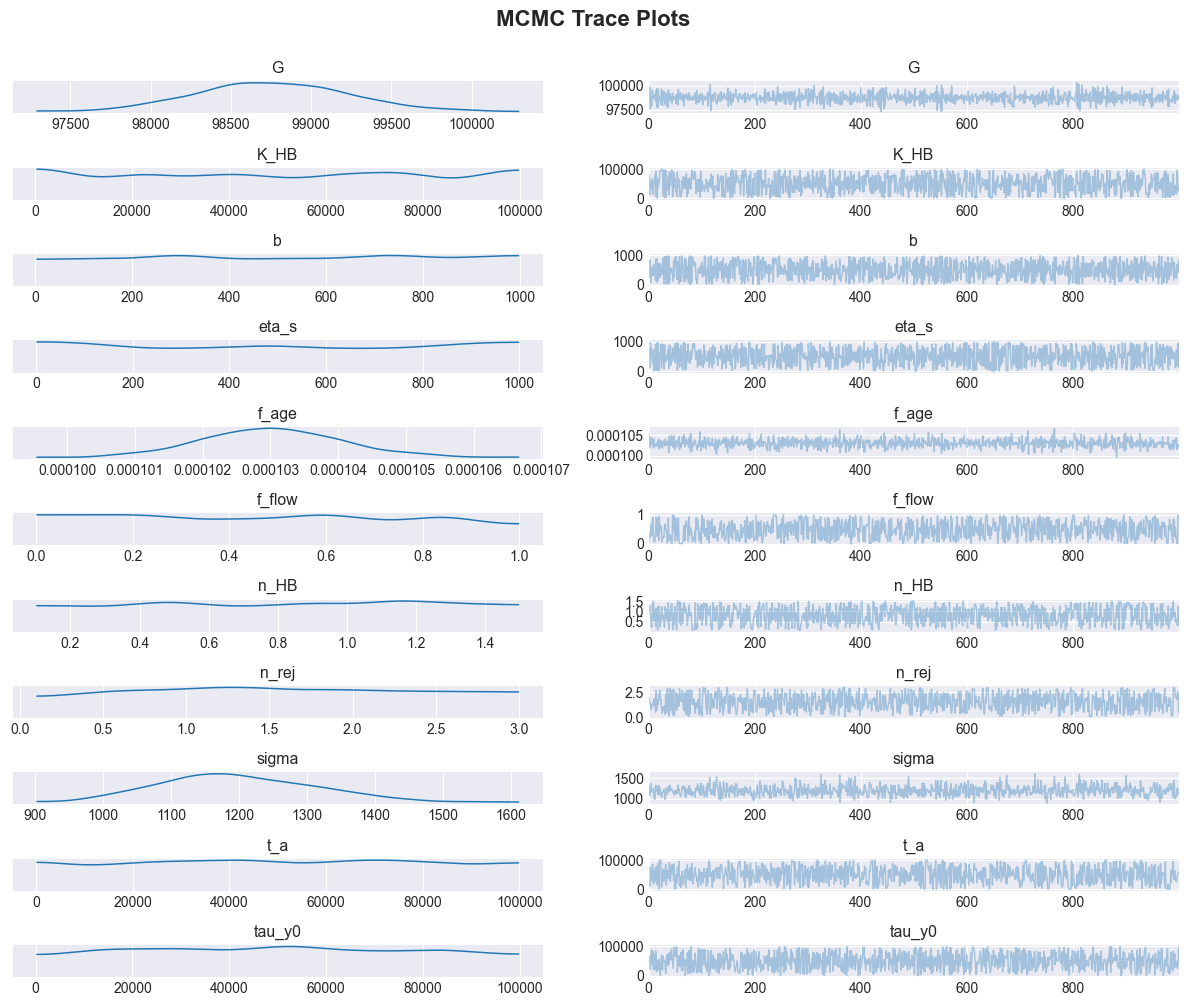

In [11]:
# Trace plots (MCMC convergence)
az.plot_trace(idata, compact=True, figsize=(12, 10))
plt.suptitle('MCMC Trace Plots', fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

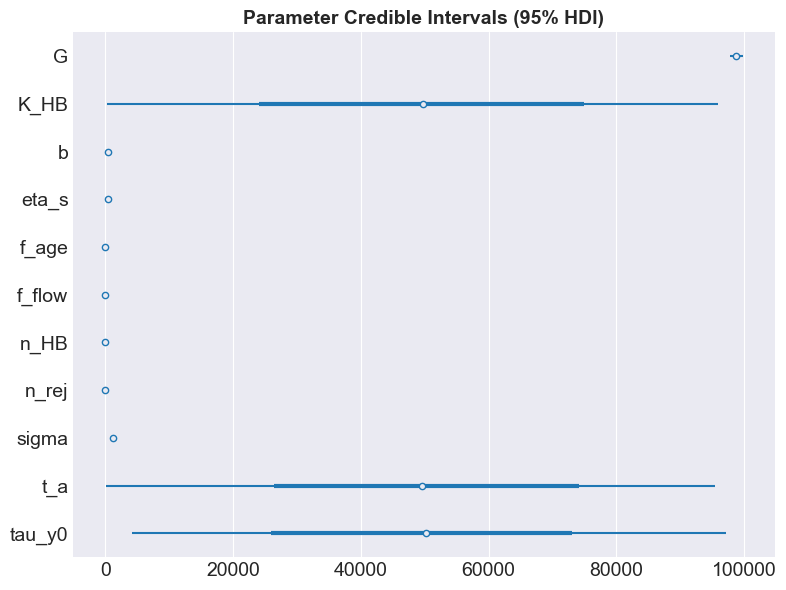

In [12]:
# Forest plot (credible intervals)
az.plot_forest(idata, hdi_prob=0.95, figsize=(8, 6))
plt.title('Parameter Credible Intervals (95% HDI)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

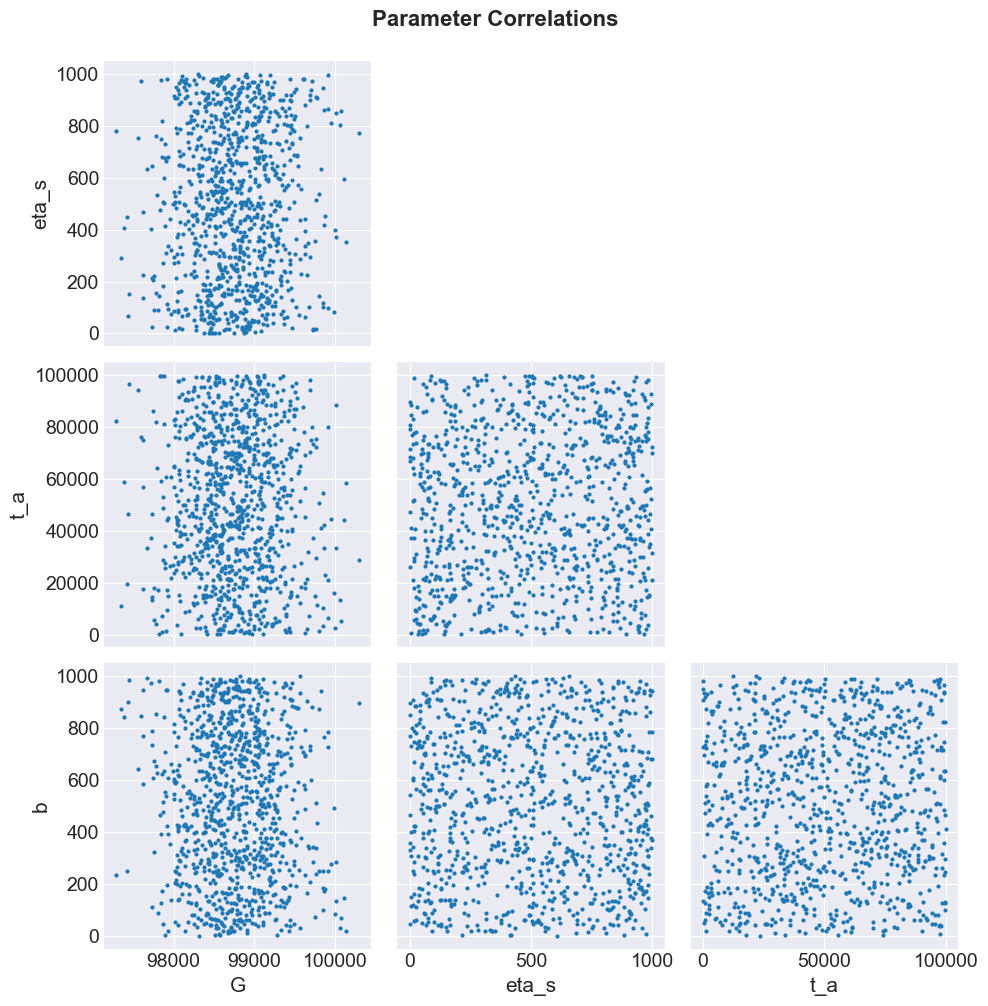

In [13]:
# Pair plot (correlations)
# Select a subset of key parameters
key_params = ['G', 'eta_s', 't_a', 'b']
key_params = [p for p in key_params if p in bayes_result.posterior_samples][:4]

if len(key_params) >= 2:
    az.plot_pair(
        idata,
        var_names=key_params,
        divergences=True,
        figsize=(10, 10)
    )
    plt.suptitle('Parameter Correlations', fontsize=16, fontweight='bold', y=1.001)
    plt.tight_layout()
    plt.show()
else:
    logger.info("Not enough parameters for pair plot")

In [14]:
# Energy plot (HMC diagnostics)
# Note: Energy plot requires sample_stats with 'energy' field
try:
    az.plot_energy(idata, figsize=(8, 5))
    plt.title('HMC Energy Diagnostic', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
except (AttributeError, KeyError) as e:
    logger.info(f"Energy plot skipped: {e}")
    logger.info("Note: Energy diagnostic requires MCMC sample stats with energy field")

## 7. Cole-Cole Plot Analysis

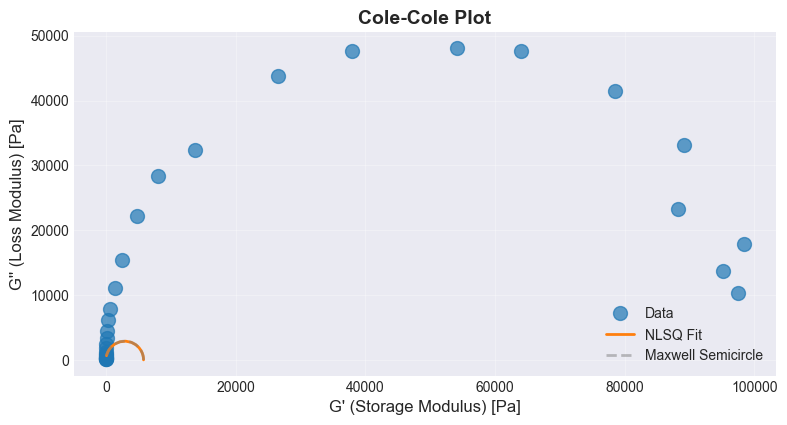

In [15]:
# Cole-Cole plot: G'' vs G' (should form semicircle for Maxwell model)
fig, ax = plt.subplots(figsize=(8, 8))

# Data
ax.plot(G_prime, G_double_prime, 'o', label='Data', markersize=10, alpha=0.7)

# NLSQ fit
ax.plot(G_prime_fit, G_double_prime_fit, '-', label='NLSQ Fit', linewidth=2)

# Theoretical semicircle (Maxwell)
G_fit_param = model.parameters.get_value('G')
theta = np.linspace(0, np.pi, 100)
G_circle = G_fit_param / 2 * (1 + np.cos(theta))
G_double_circle = G_fit_param / 2 * np.sin(theta)
ax.plot(G_circle, G_double_circle, '--', color='gray', label='Maxwell Semicircle', linewidth=2, alpha=0.5)

ax.set_xlabel("G' (Storage Modulus) [Pa]", fontsize=12)
ax.set_ylabel("G'' (Loss Modulus) [Pa]", fontsize=12)
ax.set_title('Cole-Cole Plot', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

logger.info("Cole-Cole analysis: Data should follow semicircle for ideal Maxwell behavior")

## 8. Posterior Predictive Analysis

In [16]:
# Compute credible intervals from posterior samples
posterior_samples = bayes_result.posterior_samples
n_samples = len(list(posterior_samples.values())[0])

# Random subset for efficiency (50 posterior samples for speed)
np.random.seed(42)
n_subsample = min(50, n_samples)
sample_indices = np.random.choice(n_samples, size=n_subsample, replace=False)

G_posterior_samples = []
param_names = list(model.parameters.keys())

for idx in sample_indices:
    # Set parameters from posterior sample
    for name in param_names:
        if name in posterior_samples:
            model.parameters.set_value(name, float(posterior_samples[name][idx]))
    
    G_pred = model.predict(omega, test_mode='oscillation')
    G_posterior_samples.append(G_pred)

G_posterior_samples = np.array(G_posterior_samples)

if G_posterior_samples.ndim == 3:
    G_prime_posterior = G_posterior_samples[:, :, 0]
    G_double_prime_posterior = G_posterior_samples[:, :, 1]
else:
    G_prime_posterior = G_posterior_samples
    G_double_prime_posterior = G_posterior_samples

# Compute percentiles
G_prime_median = np.median(G_prime_posterior, axis=0)
G_prime_lower = np.percentile(G_prime_posterior, 2.5, axis=0)
G_prime_upper = np.percentile(G_prime_posterior, 97.5, axis=0)

G_double_prime_median = np.median(G_double_prime_posterior, axis=0)
G_double_prime_lower = np.percentile(G_double_prime_posterior, 2.5, axis=0)
G_double_prime_upper = np.percentile(G_double_prime_posterior, 97.5, axis=0)

logger.info("Posterior predictive credible intervals computed")

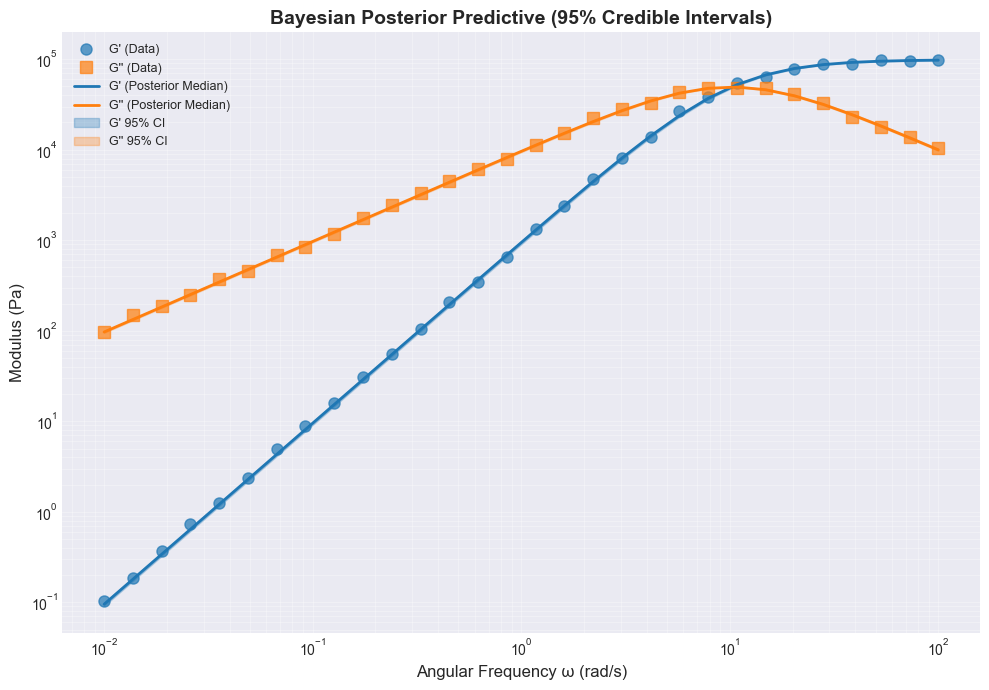

In [17]:
# Plot with credible intervals
fig, ax = plt.subplots(figsize=(10, 7))

# Data
ax.loglog(omega, G_prime, 'o', label="G' (Data)", markersize=8, alpha=0.7, color='C0')
ax.loglog(omega, G_double_prime, 's', label="G'' (Data)", markersize=8, alpha=0.7, color='C1')

# Posterior median
ax.loglog(omega, G_prime_median, '-', label="G' (Posterior Median)", linewidth=2, color='C0')
ax.loglog(omega, G_double_prime_median, '-', label="G'' (Posterior Median)", linewidth=2, color='C1')

# 95% credible intervals
ax.fill_between(omega, G_prime_lower, G_prime_upper, alpha=0.3, color='C0', label="G' 95% CI")
ax.fill_between(omega, G_double_prime_lower, G_double_prime_upper, alpha=0.3, color='C1', label="G'' 95% CI")

ax.set_xlabel('Angular Frequency ω (rad/s)', fontsize=12)
ax.set_ylabel('Modulus (Pa)', fontsize=12)
ax.set_title('Bayesian Posterior Predictive (95% Credible Intervals)', fontsize=14, fontweight='bold')
ax.legend(fontsize=9, loc='best')
ax.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Results

In [18]:
# Create output directory
import json
output_dir = Path('../outputs/fluidity/saramito_local/saos')
output_dir.mkdir(parents=True, exist_ok=True)

# Save NLSQ results
nlsq_results = {
    'parameters': {name: float(model.parameters.get_value(name)) for name in model.parameters.keys()},
    'r_squared': float(metrics['R2']),
    'rmse': float(metrics['RMSE']),
}

with open(output_dir / 'nlsq_results.json', 'w') as f:
    json.dump(nlsq_results, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior_samples.items()}
with open(output_dir / 'posterior_samples.json', 'w') as f:
    json.dump(posterior_dict, f)

# Save summary
summary.to_csv(output_dir / 'bayesian_summary.csv')

logger.info(f"Results saved to {output_dir}")
print(f"\nOutput files:")
print(f"  - nlsq_results.json")
print(f"  - posterior_samples.json")
print(f"  - bayesian_summary.csv")


Output files:
  - nlsq_results.json
  - posterior_samples.json
  - bayesian_summary.csv


## 10. Key Takeaways

### Physical Insights

1. **Maxwell-like SAOS behavior:**
   - Storage modulus G'(ω) transitions from ω² (viscous) to plateau (elastic)
   - Loss modulus G''(ω) exhibits peak at crossover frequency ω_c = 1/λ
   - Cole-Cole plot forms semicircle (characteristic of single relaxation time)

2. **Thixotropic signatures:**
   - Initial fluidity f_0 affects transient approach to steady oscillation
   - Equilibrium time t_eq controls structural recovery during rest periods
   - Yield stress τ_y has minimal effect in linear regime (γ_0 ≪ 1)

3. **Parameter identifiability:**
   - Elastic modulus G well-constrained by high-frequency plateau
   - Viscosity η_∞ (via fluidity) from low-frequency slope G'' ~ ω
   - Relaxation time λ from crossover frequency ω_c
   - Thixotropic parameters (b, n, t_eq) weakly identifiable from SAOS alone

### Computational Best Practices

4. **NLSQ warm-start critical:**
   - Bayesian inference requires good initialization (use `.fit()` first)
   - Multi-start optimization recommended for complex models
   - Check R² > 0.95 before proceeding to Bayesian

5. **Diagnostic interpretation:**
   - R-hat < 1.01: chains converged
   - ESS > 400: sufficient effective samples
   - Energy plot: marginal/conditional distributions should match
   - Divergences: indicate problematic geometry (reparameterize or increase warmup)

6. **Model validation:**
   - Cole-Cole semicircle confirms Maxwell backbone
   - Residuals < 5% indicate good fit
   - Posterior predictive intervals should encompass data

### Experimental Design

7. **Frequency sweep strategy:**
   - Log-spaced frequencies spanning 3-4 decades
   - Include both low (viscous) and high (elastic) frequency limits
   - Strain amplitude γ_0 < 1% to ensure linear regime

8. **Pre-shearing protocol:**
   - Control initial fluidity f_0 via rest time after pre-shear
   - Long rest (t ≫ t_eq): fully structured (f → f_min)
   - Short rest (t ≪ t_eq): partially rejuvenated (f > f_min)

### Next Steps

- **LAOS (Large-Amplitude Oscillatory Shear):** Nonlinear viscoelasticity and yield transition
- **Startup flows:** Stress overshoot and thixotropic kinetics
- **Step-strain relaxation:** Direct probe of relaxation time spectrum
- **Combined protocols:** Simultaneous fitting of SAOS + flow curves for full parameter identification